# LTKHDL - Final Project

(Cập nhật lần cuối: 10/1/2022)
<h3> Thành viên nhóm: </h3>
 - Nguyễn Tuấn Anh - 18120110 <br>
 - Chương Việt Hoàng - 18120124 <br>
 - Lê Thị Tuyết Trinh - 18120616 <br>


---

## Môi trường code

In [2]:
import sys
sys.executable

'D:\\anaconda3\\python.exe'

Nếu không có vấn đề gì thì file chạy python sẽ là file của môi trường code "min_ds-env".

---

## Import các thư viện cần thiết

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# YOUR CODE HERE (OPTION) 

---

## Thu thập dữ liệu

Trong đồ án này, nhóm em sửa dụng dữ liệu đã được thu thập sẵn là file "review_mbbank.csv" đính kèm; đây là dữ liệu về đánh giá của người dùng về app MB Bank. Dữ liệu này được crawl từ Google Play và gốc của dữ liệu là [ở đây]().

---

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [4]:
df_review = pd.read_csv('review_mbbank.csv')
df_review

,ID,reviewer,content,date_time,rate
0,0,Lew Lew,"MB cái gì cũng được, trừ cái otp ngu ngốc, mỗi...",18-07-21 18:34,3
1,1,Đạt Nguyễn Js,Giới thiệu rồi có thông báo rồi mà ko nhận đc ...,14-07-21 18:08,1
2,2,ha duc,App đòi quản lý nhiều quá,13-07-21 8:49,1
3,3,Thịnh Hà,Chẳng nhận được 30k và 1k điểm khi được giới t...,11-11-21 18:56,4
4,4,Deee Yuuu,tốt,22-06-21 18:31,5
...,...,...,...,...,...
13894,13894,yen ho,Ứng dụng dì mà được thưởng mà ko nhận được,19-03-21 22:28,2
13895,13895,Nhân Nguyễn Thành Nhân,Tốt cho 5 sao luôn,10-03-21 15:35,5
13896,13896,Chieu Thien,Rất tốt. Riêng e cảm nhận thì chuyển tiền hay ...,23-09-21 9:49,5
13897,13897,Tuấn Lê,Cập nhật xong thì k vào đc ứng dụng nữa. Ứng d...,27-07-21 23:05,1


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

Tính số dòng và số cột (không được code cứng con số) và lần lượt lưu vào 2 biến là `num_rows` và `num_cols`. 

In [5]:
# YOUR CODE HERE
num_rows, num_cols = df_review.shape

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Đây là dữ liệu được crawl từ bên Google Play về với nội dung là review của khách hàng nên nhóm em nghĩ sẽ có nhiều vấn đề ví dụ như bị trùng lặp dữ liệu, kiểu dữ liệu,...

### Dữ liệu có các dòng bị lặp không?

Bạn sẽ kiểm tra vụ này và lưu kết quả vào biến `have_duplicated_rows`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược. Gợi ý: dataframe có phương thức `duplicated`.

In [6]:
# YOUR CODE HERE
#TODO: Check have_duplicated_rows
have_duplicated_rows = df_review.duplicated().any()
print(have_duplicated_rows)

False


### Mỗi cột có ý nghĩa gì?

Dưới đây là phần mô tả của dữ liệu:
- **ID**: a unique identifier for each observation.
- **reviewer**: the account's name.
- **content**: the content of reviewer.
- **date_time**: date the reviewer take review.
- **rate**: rating of reviewer for app.

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Nhóm em lấy `dtype` (kiểu dữ liệu của mỗi phần tử) của mỗi cột trong `df_review` và lưu kết quả vào series `col_dtypes`; series này có index là tên cột. 

In [7]:
# YOUR CODE HERE
col_dtypes = df_review.dtypes
print(col_dtypes)

ID            int64
reviewer     object
content      object
date_time    object
rate          int64
dtype: object


**Cột có dtype là object nghĩa là sao?**

`df_review` có 3 cột có `dtype` là `object`: reviewer, content, date_time
Chúng em viết hàm nhận đầu vào là một cột `s` (series) có `dtype` là `object` và trả về tập các kiểu dữ liệu thật sự có trong cột này. (Sử dụng series.apply())

In [8]:
def open_object_dtype(s):
    dtypes = set()
    # YOUR CODE HERE
    col = pd.Series(s)
    result = col.apply(lambda x: type(x))
    dtypes = set(result)
    return dtypes
print(open_object_dtype(df_review['reviewer']))
print(open_object_dtype(df_review['content']))
print(open_object_dtype(df_review['date_time']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


**Vấn đề cần tiền xử lý:**

- Cột "date_time" đang có dtype là `str`. Để có thể tiếp tục khám phá thêm về cột này, ta sẽ thực hiện bước tiền xử lý là chuyển sang dạng `datetime`.
- Cột "content" đang có dtype là `str`, cần kiểm tra xem có dòng content nào là chuỗi rỗng không (vì đánh giá trên google play người dùng có thể nhập chuỗi gồm các khoảng trắng và submit được).
- Cột "reviewer" đang có dtype là `str`, có lẽ cột này không có giá trị rỗng nào

---

## Tiền xử lý

### Chuyển dtype của cột "date_time" sang datetime (0.5đ)

Nhóm em chuyển `dtype` của cột "date_time" sang kiểu dữ liệu thời gian (sau khi làm xong thì cột "date_time" trong `df_review` phải thay đổi `dtype`). Nhóm em dùng câu lệnh `pd.to_datetime`; khi dùng `pd.to_datetime`, bạn truyền giá trị phù hợp cho tham số `format` (nếu không thì sẽ chạy rất chậm vì Pandas phải đoán format).

In [9]:
# YOUR CODE HERE
df_review['date_time'] = pd.to_datetime(df_review['date_time'], format="%d-%m-%y %H:%M")
# Nếu dtype của cột "Date" đã được chuyển sang datetime thì phải dùng được .dt.
assert df_review['date_time'].dt.year.min() == 2021 

### Chuyển các giá trị chuỗi trống (chỉ chứa khoảng trắng) sang NaN

Nhóm em sẽ chuyển các giá trị trống (nếu có) của cột "content" sang NaN, vì thực tế người dùng khi đánh giá app có thể nhập chuỗi trống vào và submit được.

In [10]:
# YOUR CODE HERE (x.isspace() or not x)
#replace all string " " in column District and CommunityArea
df_review['content'] = df_review['content'].replace(r'^\s+$', np.nan, regex=True)
print(df_review['content'].isna().sum())


0


Có thể thấy, không có dòng nào trong content là rỗng, bây giờ chúng em sẽ thực hiên khám phá dữ liệu và trả lời câu hỏi có ý nghĩa.

### Phân tích năm 

In [11]:
# YOUR CODE HERE
col_year = df_review['date_time'].dt.year
col_year = set(col_year)
print(col_year)

{2021}


Em lấy các năm trong thời gian review thì thấy các review này đều được lấy trong năm 2021 vậy nên tạm thời về năm không có nhiều thứ cần khai thác, nên nhóm em sẽ lấy ra các tháng để phân tích sâu hơn.

### Thêm cột "Month" vào dataframe (0.5đ)

In [12]:
# YOUR CODE HERE
df_review['Month'] = df_review['date_time'].dt.month
df_review.head()

,ID,reviewer,content,date_time,rate,Month
0,0,Lew Lew,"MB cái gì cũng được, trừ cái otp ngu ngốc, mỗi...",2021-07-18 18:34:00,3,7
1,1,Đạt Nguyễn Js,Giới thiệu rồi có thông báo rồi mà ko nhận đc ...,2021-07-14 18:08:00,1,7
2,2,ha duc,App đòi quản lý nhiều quá,2021-07-13 08:49:00,1,7
3,3,Thịnh Hà,Chẳng nhận được 30k và 1k điểm khi được giới t...,2021-11-11 18:56:00,4,11
4,4,Deee Yuuu,tốt,2021-06-22 18:31:00,5,6


### Tự thêm các điều cần xử lý ở đây

Lý giải các điều cần xử lý

---

## Khám phá dữ liệu 

### Trong cột rate, số lượng mỗi điểm là bao nhiêu?

Cột rate chứa điểm số mà người dùng đánh giá cho app, viết hàm để tính số lượng từng điểm (1 - 5) và vẽ biểu đồ

1    6699
2     736
3     686
4     647
5    5131
Name: rate, dtype: int64


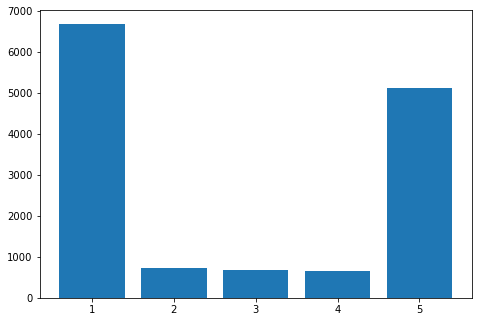

In [13]:
# YOUR CODE HERE
#Hàm để tính min, max, missing_ratio của dfcol được truyền vào
rate_count = df_review['rate'].value_counts()
rate_count = rate_count.sort_index()
print(rate_count)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rate_count.index,rate_count)
plt.show()

Nhìn biểu đồ có thể thấy số lượt rate 1 sao và 5 sao cho app là chiếm đa số, trong đó app bị rate 1 sao nhiều nhất (6699 người đánh giá 1 sao).

### Reviewer review bao nhiêu lần?

1     11518
2       539
3       143
4        50
5        22
6        17
7        12
8         9
9         8
10        4
11        5
12        1
13        2
14        4
15        3
Name: reviewer, dtype: int64


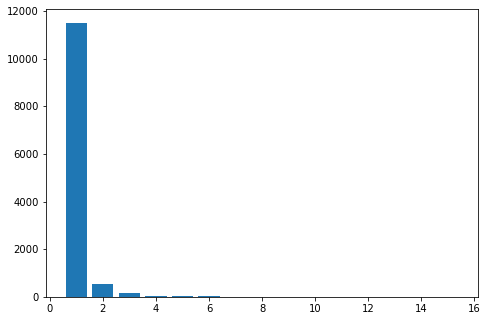

In [14]:
review_count = df_review['reviewer'].value_counts()
review_count = review_count.value_counts()
review_count = review_count.sort_index()
print(review_count)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(review_count.index,review_count)
plt.show()

Ta có thể thấy phần lớn reviewer chỉ review 1 lần. Số lần review của reviewer giảm dần.

### Rating trung bình theo số lần reviewer review?

    count      rate
0       1  2.770794
1       2  2.721707
2       3  2.743590
3       4  2.460000
4       5  2.800000
5       6  2.843137
6       7  2.845238
7       8  2.833333
8       9  3.027778
9      10  2.825000
10     11  2.890909
11     12  2.916667
12     13  2.307692
13     14  3.250000
14     15  3.266667


C:\Users\CVH\AppData\Local\Temp/ipykernel_12644/2340567837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = pd.DataFrame([(reviewer == x).sum() for x in reviewer], columns = ['count'])


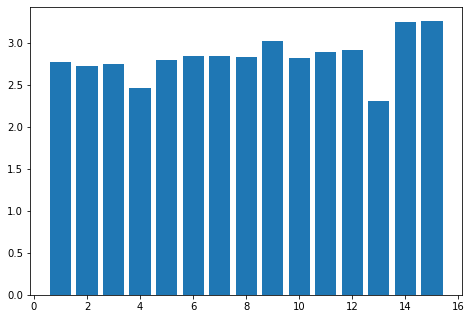

In [72]:
df = df_review[['reviewer', 'rate']]
reviewer = df['reviewer'].to_numpy()
df['count'] = pd.DataFrame([(reviewer == x).sum() for x in reviewer], columns = ['count'])
df = df[['rate', 'count']].groupby('count').mean().reset_index()

print(df)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df['count'],df['rate'])
plt.show()

Biểu đồ không cho thấy sự thay đổi, các reviewer review 14 và 15 lần có rating trung bình cao nhất.

### Rating thay đổi như thế nào theo tháng?

#### Ngày đầu tiên và ngày cuối cùng được review?

In [22]:
begin_date = df_review['date_time'].min() 
end_date = df_review['date_time'].max()
print(begin_date)
print(end_date)

2021-02-07 23:33:00
2021-12-16 17:36:00


#### Số review thay đổi thế nào theo tháng?

    Month  rate
0       2   316
1       3   919
2       4   945
3       5   762
4       6  1260
5       7  1605
6       8  1747
7       9  1408
8      10  1632
9      11  2505
10     12   800


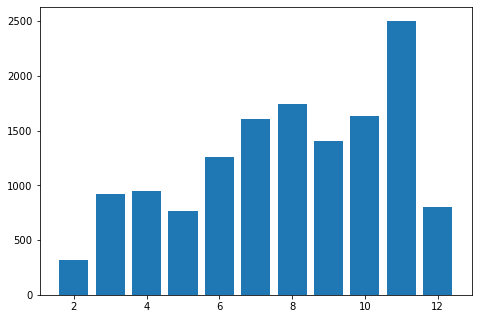

In [15]:
df = df_review[['rate', 'Month']]
df = df.groupby("Month").count().reset_index()

print(df)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df['Month'], df['rate'])
plt.show()

Số rating có su hướng tăng từ từ đến cuối năm, tăng mạnh và đạt đỉnh ở tháng 11 và giảm mạnh ở tháng 12. Việc giảm mạnh ở tháng 12 có thể vì ngày cuối cùng review là 16/12, chỉ mới nữa tháng 12.

#### rating thay đổi thế nào theo tháng?

    Month      rate
0       2  2.895570
1       3  2.958651
2       4  2.953439
3       5  2.822835
4       6  3.153968
5       7  2.532710
6       8  2.586720
7       9  3.128551
8      10  3.166054
9      11  2.163273
10     12  2.933750
2.7679689186272394


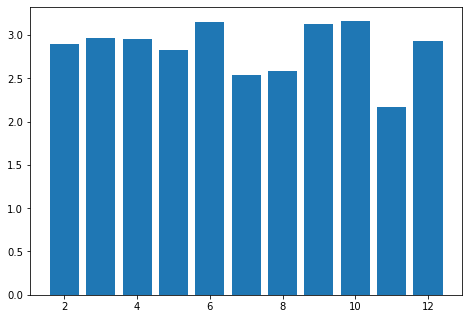

In [25]:
df = df_review[['rate', 'Month']]
df = df.groupby("Month").mean().reset_index()

print(df)
print(df_review['rate'].mean())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df['Month'], df['rate'])
plt.show()

Nhìn chung, rating thay đổi không nhiều, gần mức trung bình 2.76. Tháng 11 tuy có nhiều review nhất nhưng lại có rating chung bình thấp nhất: 2.16

### Tỷ lệ % review đúng chính tả?

Kiểm tra bằng cách check từng word trong content có nằm trong file từ vựng hay không (cách này không tối ưu nhưng cũng tương đối chính xác)

In [102]:
def func(Str):
    return all(word in vocab for word in Str)

df = df_review['content']
vocab = np.loadtxt("vocab.txt", dtype=str, encoding='utf-8')
#content = df.to_numpy()
num_correct = df.apply(func).sum() * 100 / len(df)
print(num_correct)

0.014389524426217713


Đa số review đều sai chính tả, viết tắt!

### Tự thêm các điều cần khai thác ở đây

Lý giải các điều cần khai thác

In [ ]:
# YOUR CODE HERE


---

## Đưa ra các câu hỏi cần trả lời

Sau khi đã khám phá dữ liệu và hiểu hơn về dữ liệu, ta thấy có một số câu hỏi có thể được trả lời bằng dữ liệu:
- .... (Đưa ra câu hỏi) -- Giải thích tại sao lại là câu hỏi có ý nghĩa


---

## Tiền xử lý

### Tự thêm các điều cần tiền xử lý

Lý giải điều cần tiền xử lý

In [ ]:
# YOUR CODE HERE


---

## Phân tích dữ liệu để trả lời cho các câu hỏi 

### Title -- câu hỏi của Nguyễn Tuấn Anh

Để trả lời cho câu hỏi này, bạn sẽ làm như sau:
- Bước 1: ...
- Bước 2: ...

Code bước 1. 

In [ ]:
# YOUR CODE HERE


Code bước 2. 

In [ ]:
# YOUR CODE HERE


Nhận xét: ...

### Tìm hiểu ảnh hưởng của câu từ đến rating? -- câu hỏi của Chương Việt Hoàng

Để trả lời cho câu hỏi này, bạn sẽ làm như sau:
- Bước 1: ...
- Bước 2: ...

Code bước 1. 

In [ ]:
# YOUR CODE HERE


Nhận xét: 

Code bước 2.

In [ ]:
# YOUR CODE HERE

### Title -- câu hỏi của Lê Thị Tuyết Trinh

Để trả lời cho câu hỏi này, bạn sẽ làm như sau:
- Bước 1: ...
- Bước 2: ...

Code bước 1. 

In [ ]:
# YOUR CODE HERE

Code bước 2. 

In [ ]:
# YOUR CODE HERE

Nhận xét: ...